In [1]:
import sys
import cPickle as pickle
import gzip
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors

sys.path.append("../utils/")
from Histogram import *
import WinProbabilities as wp

In [2]:
## Load in pitch data dataframes from pre-saved pickles

fins = [
     "../output_fromJSON/pitches_2014.pkl.gz",
     "../output_fromJSON/pitches_2015.pkl.gz",
     "../output_fromJSON/pitches_2016.pkl.gz",
     "../output_fromJSON/pitches_2017.pkl.gz",
     "../output_fromJSON/pitches_2018.pkl.gz",
     "../output_fromJSON/pitches_2019.pkl.gz",
]
dfs = []
for fin in fins:
    dfs.append(pd.read_pickle(fin, compression="gzip"))
df = pd.concat(dfs, ignore_index=True)
df["year"] = df.date.apply(lambda x:x.year)

print "shape:", df.shape

## Load win probabilities
wp.LoadWinProbFile("../data/win_probabilities.pkl")
wp.LoadCountOutcomeFile("../data/count_outcomes.json")
wp.LoadRunExpectancies("../data/run_expectancies_by_event.pkl")

shape: (4363258, 67)


In [13]:
gid = (2016,8,3,"mia","chn")

game = df.loc[(df.date.apply(lambda x: x.year==gid[0] and x.month==gid[1] and x.day==gid[2])) & \
               (df.away_team == gid[3]) & (df.home_team == gid[4]) ].copy()


In [14]:
def get_wprob(row):
    return wp.GetHomeWinProb(row.inning, row.half, row.base_state, row.outs, row.away_score, row.home_score)
def get_cb_wprob(row):
    return wp.GetCountBasedWinProb(row.inning, row.half, row.base_state, row.outs, 
                             row.away_score, row.home_score, row.balls, row.strikes)
game["wprob"] = game.apply(get_wprob, axis="columns")
game["cb_wprob"] = game.apply(get_cb_wprob, axis="columns")

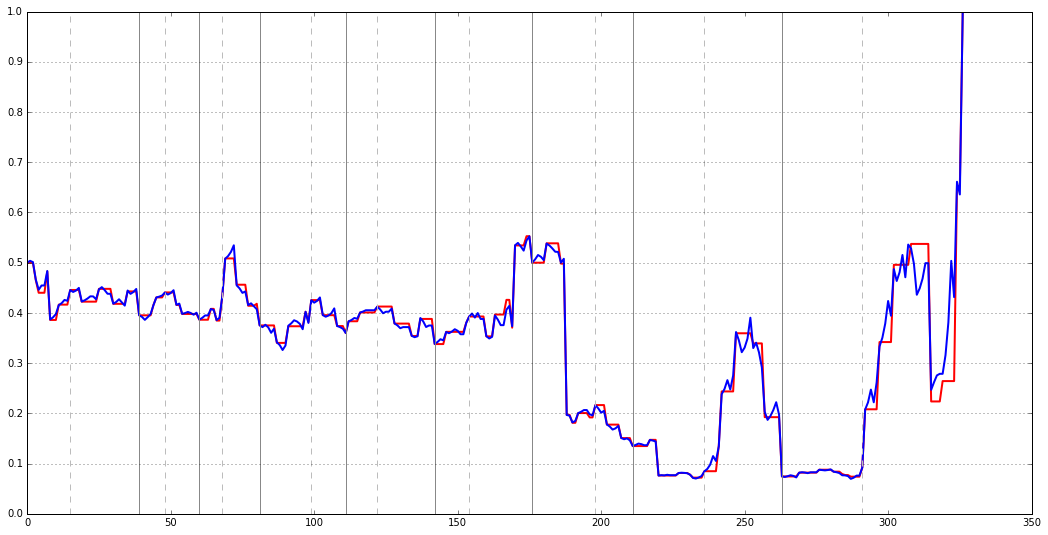

In [15]:
# start_ab = game.drop_duplicates(["inning","half","base_state","outs","away_score","home_score","wprob"])
start_ab = game.query("balls>-1")
probs = start_ab.wprob.values
probs_cb = start_ab.cb_wprob.values
innings = (start_ab.inning*(start_ab.half.apply(lambda x:-1 if str(x)=="top" else 1).astype(int))).values
change_idxs = np.where(innings[:-1] != innings[1:])[0] + 1

lastval = 1.0 if game.home_score_afterInn.iloc[-1]>game.away_score_afterInn.iloc[-1] else 0.0
probs = np.append(probs, lastval)
probs_cb = np.append(probs_cb, lastval)

x = np.arange(probs.size)
plt.figure(figsize=(18,9))
plt.plot(x, probs, 'r-', lw=2)
plt.plot(x, probs_cb, 'b-', lw=2)
for idx in change_idxs[0::2]:
    plt.plot([idx,idx],[0,1], '--', color='#bcbcbc')
for idx in change_idxs[1::2]:
    plt.plot([idx,idx],[0,1], '-', color='#888888')
plt.gca().set_ylim(0,1)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().grid(axis='y')

In [17]:
game["wp_diff"] = game.cb_wprob-game.wprob
game[["inning","half","balls","strikes","outs","base_state","away_score","home_score","wprob","cb_wprob","wp_diff"]] \
    .sort_values("wp_diff", ascending=True).head()

,inning,half,balls,strikes,outs,base_state,away_score,home_score,wprob,cb_wprob,wp_diff
1894411,9,bottom,0,2,1,6,4,3,0.537402,0.436163,-0.101238
1894412,9,bottom,1,2,1,6,4,3,0.537402,0.448817,-0.088584
1894413,9,bottom,2,2,1,6,4,3,0.537402,0.468211,-0.069190
1894357,8,bottom,1,2,1,6,4,2,0.339301,0.291546,-0.047755
1894410,9,bottom,0,1,1,6,4,3,0.537402,0.497514,-0.039888


In [7]:
import multiprocessing as mp

def add_wprobs(df):
    df["wprob"] = df.apply(get_wprob, axis="columns")
    df["cb_wprob"] = df.apply(get_cb_wprob, axis="columns")
    return df

def parallelize(df, func, ncores):
    print "Splitting..."
    df_split = np.array_split(df, ncores)
    pool = mp.Pool(ncores)
    print "Running over {0} cores".format(ncores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
    
subset = df[["date","away_team","home_team","gamePk","inning","half","balls","strikes","outs",
             "base_state","away_score","home_score"]]
subset = parallelize(subset, add_wprobs, 10)

TEST1
TEST2
Splitting...
Running over 10 cores


In [12]:
subset["wp_diff"] = subset.cb_wprob - subset.wprob
subset.sort_values("wp_diff",ascending=False).head(10)

,date,away_team,home_team,gamePk,inning,half,balls,strikes,outs,base_state,away_score,home_score,wprob,cb_wprob,wp_diff
1894423,2016-08-03 13:20:00,mia,chn,448465,9,bottom,3,0,2,7,4,3,0.264277,0.503698,0.239421
3998232,2019-07-02 19:10:00,ari,lan,565842,9,bottom,3,0,2,7,4,3,0.264277,0.503698,0.239421
4301490,2019-09-17 19:10:00,sfn,bos,565102,13,bottom,3,0,2,7,6,5,0.264277,0.503698,0.239421
3714423,2019-04-21 13:05:00,min,bal,564939,9,bottom,3,0,2,7,4,3,0.264277,0.503698,0.239421
3345062,2018-07-26 19:10:00,min,bos,530950,9,bottom,3,0,2,7,2,1,0.264277,0.503698,0.239421
1347410,2015-09-18 19:08:00,kca,det,415850,12,bottom,3,0,2,7,4,3,0.264277,0.503698,0.239421
3245645,2018-06-28 13:10:00,min,cha,530619,9,bottom,3,0,2,7,1,0,0.264277,0.503698,0.239421
3168760,2018-06-09 13:07:00,bal,tor,530360,10,bottom,3,0,2,7,3,3,0.652873,0.855635,0.202762
2783647,2017-09-09 19:10:00,mia,atl,492222,9,bottom,3,0,2,7,5,5,0.652873,0.855635,0.202762
1611837,2016-05-21 19:10:00,lan,sdn,447508,11,bottom,3,0,2,7,2,2,0.652873,0.855635,0.202762
